c:\Users\dpnim\miniconda3\envs\machine_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading data...
Preprocessing...
Starting Training...


Training:  35%|███▌      | 7/20 [01:23<02:39, 12.30s/it, Loss=0.0291, Val AUC=0.8408]

  [Scheduler] Epoch 7: LR reduced from 0.001 to 0.0005


Training:  50%|█████     | 10/20 [02:03<02:08, 12.90s/it, Loss=0.0287, Val AUC=0.8393]

  [Scheduler] Epoch 10: LR reduced from 0.0005 to 0.00025


Training:  65%|██████▌   | 13/20 [02:40<01:27, 12.55s/it, Loss=0.0285, Val AUC=0.8391]

  [Scheduler] Epoch 13: LR reduced from 0.00025 to 0.000125


Training:  80%|████████  | 16/20 [03:17<00:49, 12.29s/it, Loss=0.0284, Val AUC=0.8397]

  [Scheduler] Epoch 16: LR reduced from 0.000125 to 6.25e-05


Training:  95%|█████████▌| 19/20 [03:51<00:11, 11.74s/it, Loss=0.0284, Val AUC=0.8398]

  [Scheduler] Epoch 19: LR reduced from 6.25e-05 to 3.125e-05


Training: 100%|██████████| 20/20 [04:03<00:00, 12.15s/it, Loss=0.0284, Val AUC=0.8396]


Training Complete. Best Val AUC: 0.8418

--- Best F1 Optimization ---
Optimal Threshold: 0.4456
Resulting Recall:  0.7080
Resulting Precision: 0.5729
Max F1 Score:      0.6333

--- Final Test Report ---
              precision    recall  f1-score   support

         0.0       0.84      0.75      0.79     89173
         1.0       0.57      0.71      0.63     42676

    accuracy                           0.73    131849
   macro avg       0.71      0.73      0.71    131849
weighted avg       0.76      0.73      0.74    131849



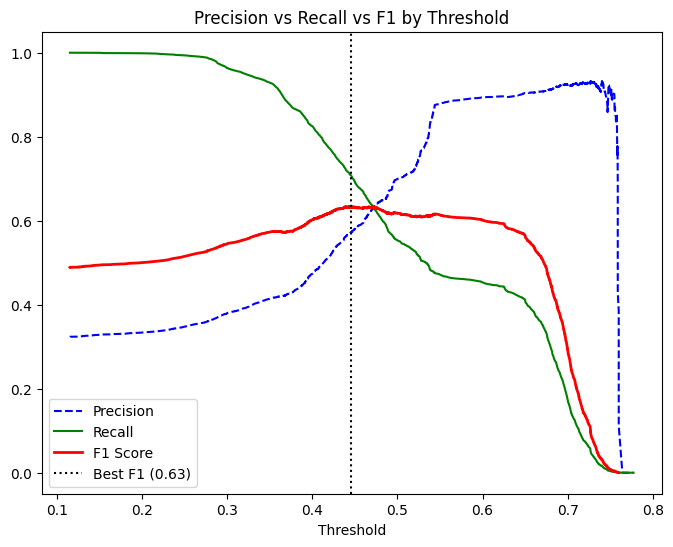

[Test (tuned)]
              precision    recall  f1-score   support

         0.0      0.842     0.747     0.792     89173
         1.0      0.573     0.708     0.633     42676

    accuracy                          0.735    131849
   macro avg      0.708     0.728     0.713    131849
weighted avg      0.755     0.735     0.741    131849

AUC-PR: 0.7242 | AUC-ROC: 0.8094


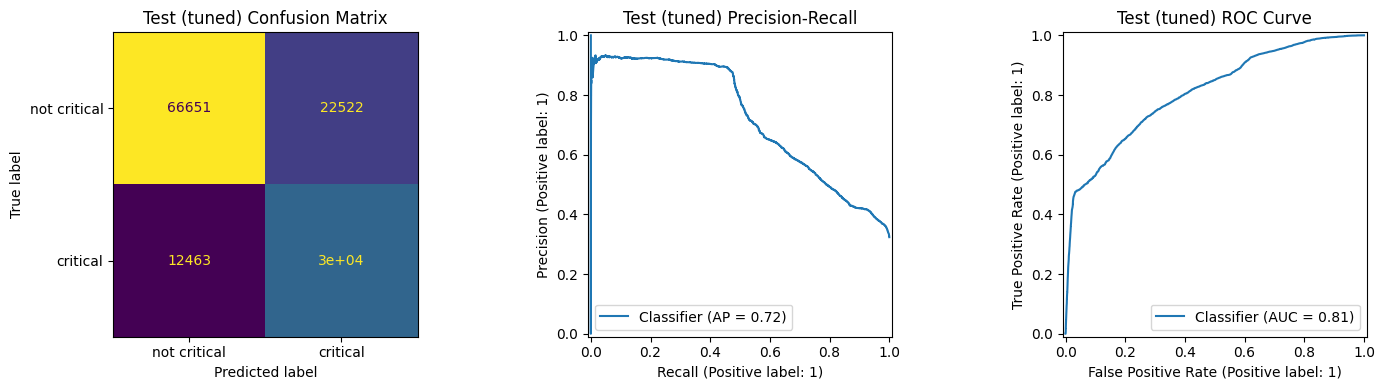

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm  # <--- Added for progress tracking

# --- Configuration ---
DATA_DIR = Path("../data_final")
TRAIN_PATH = DATA_DIR / "vm_train.parquet"
VAL_PATH   = DATA_DIR / "vm_val.parquet"
TEST_PATH  = DATA_DIR / "vm_test.parquet"

TARGET_COL = "critical"
BATCH_SIZE = 2048
EPOCHS = 20
LEARNING_RATE = 0.001
EMBEDDING_DIM = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load Data
# ------------------------------------------------------------------------------
print("Loading data...")
df_train = pl.read_parquet(TRAIN_PATH)
df_val   = pl.read_parquet(VAL_PATH)
df_test  = pl.read_parquet(TEST_PATH)

# 2. Strict Safe Features
# ------------------------------------------------------------------------------
feat_timing = ["day_idx", "hour_of_day", "ts_vm_created", "ts_first_vm_created"]
feat_static = [
    "vm_virtual_core_count", "vm_memory_gb", "vm_mem_per_core", 
    "deployment_size", "log_deployment_size", "count_vms_created", 
    "sub_first_day", "sub_first_hour"
]
feat_history = [c for c in df_train.columns if c.startswith("hist_")]

NUMERIC_COLS = feat_timing + feat_static + feat_history
CAT_COLS = ["vm_category", "subscription_id"]

# 3. Preprocessing
# ------------------------------------------------------------------------------
print("Preprocessing...")

def prepare_pandas(df_polars):
    return df_polars.select(NUMERIC_COLS + CAT_COLS + [TARGET_COL]).to_pandas()

X_train = prepare_pandas(df_train)
X_val   = prepare_pandas(df_val)
X_test  = prepare_pandas(df_test)

# Scale Numerics
scaler = StandardScaler()
X_train[NUMERIC_COLS] = scaler.fit_transform(X_train[NUMERIC_COLS].fillna(0))
X_val[NUMERIC_COLS]   = scaler.transform(X_val[NUMERIC_COLS].fillna(0))
X_test[NUMERIC_COLS]  = scaler.transform(X_test[NUMERIC_COLS].fillna(0))

# Encode Categoricals
cat_dims = {}
for col in CAT_COLS:
    le = LabelEncoder()
    vals = X_train[col].astype(str).unique()
    le.fit(np.append(vals, "<UNK>"))
    
    def safe_transform(series):
        series = series.astype(str)
        mask = series.isin(le.classes_)
        series[~mask] = "<UNK>"
        return le.transform(series)
    
    X_train[col] = safe_transform(X_train[col])
    X_val[col]   = safe_transform(X_val[col])
    X_test[col]  = safe_transform(X_test[col])
    cat_dims[col] = len(le.classes_)

# 4. Dataset & Model
# ------------------------------------------------------------------------------
class VMDataset(Dataset):
    def __init__(self, df, num_cols, cat_cols):
        self.num = torch.tensor(df[num_cols].values, dtype=torch.float32)
        self.cat = torch.tensor(df[cat_cols].values, dtype=torch.long)
        self.y   = torch.tensor(df[TARGET_COL].values, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.num[i], self.cat[i], self.y[i]

train_loader = DataLoader(VMDataset(X_train, NUMERIC_COLS, CAT_COLS), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(VMDataset(X_val, NUMERIC_COLS, CAT_COLS), batch_size=BATCH_SIZE)
test_loader  = DataLoader(VMDataset(X_test, NUMERIC_COLS, CAT_COLS), batch_size=BATCH_SIZE)

class Net(nn.Module):
    def __init__(self, num_dim, cat_dims):
        super().__init__()
        self.emb_cat = nn.Embedding(cat_dims['vm_category'], 4)
        self.emb_sub = nn.Embedding(cat_dims['subscription_id'], EMBEDDING_DIM)
        
        in_dim = num_dim + 4 + EMBEDDING_DIM
        
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128),    nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64),     nn.BatchNorm1d(64),  nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
        
    def forward(self, x_num, x_cat):
        e1 = self.emb_cat(x_cat[:,0])
        e2 = self.emb_sub(x_cat[:,1])
        x = torch.cat([x_num, e1, e2], dim=1)
        return self.mlp(x)

model = Net(len(NUMERIC_COLS), cat_dims).to(device)

# 5. Training with TQDM & Fixed Scheduler
# ------------------------------------------------------------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        bce = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        return (self.alpha * (1-pt)**self.gamma * bce).mean()

criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# FIX: Remove 'verbose=True'
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

print("Starting Training...")
best_val_auc = 0

# TQDM Progress Bar for Epochs
pbar = tqdm(range(EPOCHS), desc="Training")

for epoch in pbar:
    model.train()
    total_loss = 0
    
    # Optional: Inner loop progress bar for batches if epochs are very long
    # for xn, xc, y in tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}"):
    for xn, xc, y in train_loader:
        xn, xc, y = xn.to(device), xc.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xn, xc), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    
    # Validation
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xn, xc, y in val_loader:
            xn, xc, y = xn.to(device), xc.to(device), y.to(device)
            preds.extend(torch.sigmoid(model(xn, xc)).cpu().numpy())
            targets.extend(y.cpu().numpy())
            
    val_auc = roc_auc_score(targets, preds)
    
    # Step scheduler
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_auc)
    new_lr = optimizer.param_groups[0]['lr']
    
    if new_lr < old_lr:
        print(f"  [Scheduler] Epoch {epoch+1}: LR reduced from {old_lr} to {new_lr}")
    
    # Update Progress Bar
    pbar.set_postfix({"Loss": f"{avg_loss:.4f}", "Val AUC": f"{val_auc:.4f}"})
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model.pth")

print(f"Training Complete. Best Val AUC: {best_val_auc:.4f}")

# 6. Final Evaluation (Maximize F1)
# ------------------------------------------------------------------------------
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_preds, test_targets = [], []
with torch.no_grad():
    for xn, xc, y in test_loader:
        xn, xc, y = xn.to(device), xc.to(device), y.to(device)
        test_preds.extend(torch.sigmoid(model(xn, xc)).cpu().numpy())
        test_targets.extend(y.cpu().numpy())

test_preds = np.array(test_preds).ravel()
test_targets = np.array(test_targets).ravel()

# Optimization
precisions, recalls, thresholds = precision_recall_curve(test_targets, test_preds)
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.nanargmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n--- Best F1 Optimization ---")
print(f"Optimal Threshold: {best_thresh:.4f}")
print(f"Resulting Recall:  {recalls[best_idx]:.4f}")
print(f"Resulting Precision: {precisions[best_idx]:.4f}")
print(f"Max F1 Score:      {best_f1:.4f}")

# Final Report
final_classes = (test_preds >= best_thresh).astype(int)
print("\n--- Final Test Report ---")
print(classification_report(test_targets, final_classes))

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "r-", linewidth=2, label="F1 Score")
plt.axvline(best_thresh, color='black', linestyle=':', label=f"Best F1 ({best_f1:.2f})")
plt.legend()
plt.title("Precision vs Recall vs F1 by Threshold")
plt.xlabel("Threshold")
plt.show()
# Standardized evaluation (report + curves + confusion matrix)
def evaluate_split(y_true, scores, preds, split_name: str):
    pr_auc = average_precision_score(y_true, scores)
    roc_auc = roc_auc_score(y_true, scores)

    print(f"[{split_name}]")
    print(classification_report(y_true, preds, digits=3, zero_division=0))
    print(f"AUC-PR: {pr_auc:.4f} | AUC-ROC: {roc_auc:.4f}")

    cm = confusion_matrix(y_true, preds)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ConfusionMatrixDisplay(cm, display_labels=["not critical", "critical"]).plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f"{split_name} Confusion Matrix")
    PrecisionRecallDisplay.from_predictions(y_true, scores, ax=axes[1])
    axes[1].set_title(f"{split_name} Precision-Recall")
    RocCurveDisplay.from_predictions(y_true, scores, ax=axes[2])
    axes[2].set_title(f"{split_name} ROC Curve")
    plt.tight_layout()
    plt.show()

# Evaluate final test split with tuned threshold
evaluate_split(test_targets, test_preds, final_classes, "Test (tuned)")



STARTING FEATURE OPTIMIZATION ANALYSIS
1. Calculating Permutation Importance...
   Baseline Validation AUC: 0.84179


   > Found 5 features with <= 0 importance.
2. Checking for Multicollinearity (>0.95)...
   > Found 3 highly correlated features.

DROPPING 7 FEATURES: ['ts_vm_created', 'day_idx', 'deployment_size', 'hist_n_critical', 'vm_mem_per_core', 'hist_has_past', 'sub_first_day']

Retraining with 15 Numeric Features (Original: 22)...
   Training Epochs:
   Ep 20/20 | Val AUC: 0.8422
   Training Complete. Best Optimized Val AUC: 0.8450

FINAL OPTIMIZED PERFORMANCE REPORT
Selected Threshold: 0.4419
ROC AUC:  0.8107
PR AUC:   0.7216
Max F1:   0.6326
------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0     0.8353    0.7738    0.8034     89173
         1.0     0.5904    0.6813    0.6326     42676

    accuracy                         0.7438    131849
   macro avg     0.7129    0.7275    0.7180    131849
weighted avg     0.7560    0.7438    0.7481    131849



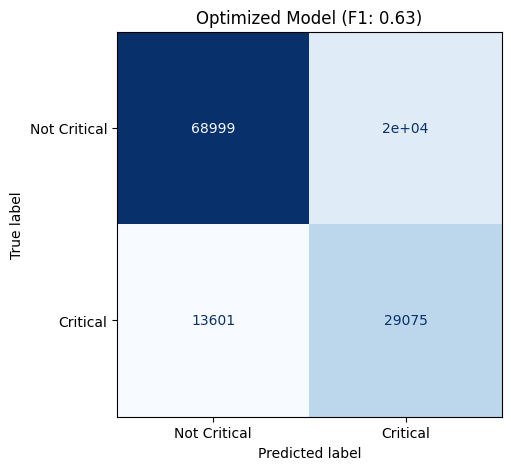

In [2]:
# ==============================================================================
# AUTOMATED FEATURE SELECTION & RETRAINING BLOCK
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, precision_recall_curve

# 1. Helper Function for Predictions
def get_all_preds(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xn, xc, y in loader:
            xn, xc, y = xn.to(device), xc.to(device), y.to(device)
            p = torch.sigmoid(model(xn, xc)).cpu().numpy()
            preds.extend(p)
            targets.extend(y.cpu().numpy())
    return np.array(preds).ravel(), np.array(targets).ravel()

print("\n" + "="*50)
print("STARTING FEATURE OPTIMIZATION ANALYSIS")
print("="*50)

# 2. Permutation Importance (Numeric Cols Only to protect Embeddings)
print("1. Calculating Permutation Importance...")
base_preds, base_targets = get_all_preds(model, val_loader, device)
baseline_auc = roc_auc_score(base_targets, base_preds)
print(f"   Baseline Validation AUC: {baseline_auc:.5f}")

importances = {}
# Check numeric features
for feat in tqdm(NUMERIC_COLS, desc="Permuting Numerics", leave=False):
    temp_df = X_val.copy()
    temp_df[feat] = np.random.permutation(temp_df[feat].values)
    
    # Create temp loader
    temp_ds = VMDataset(temp_df, NUMERIC_COLS, CAT_COLS)
    temp_loader = DataLoader(temp_ds, batch_size=4096, shuffle=False)
    
    perm_preds, _ = get_all_preds(model, temp_loader, device)
    perm_auc = roc_auc_score(base_targets, perm_preds)
    importances[feat] = baseline_auc - perm_auc

# Identify Features with <= 0 Importance
zero_importance_feats = [k for k, v in importances.items() if v <= 0.0]
print(f"   > Found {len(zero_importance_feats)} features with <= 0 importance.")

# 3. Correlation Analysis (Redundancy Check)
print("2. Checking for Multicollinearity (>0.95)...")
corr_matrix = X_train[NUMERIC_COLS].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_feats = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"   > Found {len(high_corr_feats)} highly correlated features.")

# 4. Define Drop List
# We prioritize keeping 'log' features if size is correlated
drop_candidates = set(zero_importance_feats + high_corr_feats)

# Safety check: Don't drop everything
if len(drop_candidates) == len(NUMERIC_COLS):
    print("   ! Warning: Analysis suggested dropping ALL numerics. Backing off to safe mode.")
    drop_candidates = set(zero_importance_feats)

# Explicitly Prefer log_deployment_size over deployment_size if both are flagged
if "deployment_size" in drop_candidates and "log_deployment_size" in drop_candidates:
    drop_candidates.remove("log_deployment_size")

final_drop_list = list(drop_candidates)
print(f"\nDROPPING {len(final_drop_list)} FEATURES: {final_drop_list}")

# 5. RETRAINING
# ----------------------------------------------------------
NEW_NUM_COLS = [c for c in NUMERIC_COLS if c not in final_drop_list]
print(f"\nRetraining with {len(NEW_NUM_COLS)} Numeric Features (Original: {len(NUMERIC_COLS)})...")

# New Loaders
train_loader_opt = DataLoader(VMDataset(X_train, NEW_NUM_COLS, CAT_COLS), batch_size=BATCH_SIZE, shuffle=True)
val_loader_opt   = DataLoader(VMDataset(X_val, NEW_NUM_COLS, CAT_COLS), batch_size=BATCH_SIZE)
test_loader_opt  = DataLoader(VMDataset(X_test, NEW_NUM_COLS, CAT_COLS), batch_size=BATCH_SIZE)

# New Model Instance (Note: cat_dims stays same as we didn't touch categories)
model_opt = Net(len(NEW_NUM_COLS), cat_dims).to(device)
optimizer_opt = optim.Adam(model_opt.parameters(), lr=LEARNING_RATE)
scheduler_opt = optim.lr_scheduler.ReduceLROnPlateau(optimizer_opt, mode='max', factor=0.5, patience=2)

# Training Loop
best_auc_opt = 0
print("   Training Epochs:")
for epoch in range(EPOCHS):
    model_opt.train()
    for xn, xc, y in train_loader_opt:
        xn, xc, y = xn.to(device), xc.to(device), y.to(device)
        optimizer_opt.zero_grad()
        loss = criterion(model_opt(xn, xc), y)
        loss.backward()
        optimizer_opt.step()
    
    # Validation
    val_preds, val_targets = get_all_preds(model_opt, val_loader_opt, device)
    val_auc = roc_auc_score(val_targets, val_preds)
    scheduler_opt.step(val_auc)
    
    if val_auc > best_auc_opt:
        best_auc_opt = val_auc
        torch.save(model_opt.state_dict(), "best_model_opt.pth")
    
    # Simple log every epoch
    print(f"   Ep {epoch+1}/{EPOCHS} | Val AUC: {val_auc:.4f}", end="\r")

print(f"\n   Training Complete. Best Optimized Val AUC: {best_auc_opt:.4f}")

# 6. FINAL EVALUATION
# ----------------------------------------------------------
print("\n" + "="*50)
print("FINAL OPTIMIZED PERFORMANCE REPORT")
print("="*50)

# Load best weights
model_opt.load_state_dict(torch.load("best_model_opt.pth"))

# Get Test Predictions
test_preds, test_targets = get_all_preds(model_opt, test_loader_opt, device)

# Calculate Metrics
roc_auc = roc_auc_score(test_targets, test_preds)
pr_auc = average_precision_score(test_targets, test_preds)

# Find Optimal Threshold (F1 Max)
precisions, recalls, thresholds = precision_recall_curve(test_targets, test_preds)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Hard Predictions
final_classes = (test_preds >= best_thresh).astype(int)

print(f"Selected Threshold: {best_thresh:.4f}")
print(f"ROC AUC:  {roc_auc:.4f}")
print(f"PR AUC:   {pr_auc:.4f}")
print(f"Max F1:   {best_f1:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(test_targets, final_classes, digits=4))

# Confusion Matrix Visual
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_targets, final_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Critical", "Critical"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title(f"Optimized Model (F1: {best_f1:.2f})")
plt.show()